In [1]:
import splitfolders
import shutil
import os
from PIL import Image
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import keras_tuner as kt
import tensorflow_hub as hub

2024-05-17 21:04:57.103216: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-17 21:04:57.131241: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 21:04:57.653279: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Build Train/Test/Validation datasets from the given dataset.

In [2]:
def build_directory_dict(root_dir):
    directory_dict = {}

    for dirpath, dirnames, filenames in os.walk(root_dir):
        if dirpath != root_dir:
            parent_dir = os.path.basename(dirpath)
            if parent_dir not in directory_dict:
                directory_dict[parent_dir] = []
            for dirname in dirnames:
                directory_dict[parent_dir].append(dirname)

    # check if values for any key is empty then remove that key value pair from dict
    dict_copy = directory_dict.copy()
    print(dict_copy)
    for key, value in dict_copy.items():
        if not value:
            del directory_dict[key]
    return directory_dict

In [3]:
def copy_data_to_dest(source, dest, class_labels, split_ratios):

    for shape, types in class_labels.items():
        src = source + '/' + shape
        temp_dir = source + '/temp/' + shape

        if (os.path.exists(temp_dir)):
            shutil.rmtree(temp_dir) 

        splitfolders.ratio(src, output=temp_dir, ratio=split_ratios, seed=1337)
      
        for type_val in types:
            shutil.move(temp_dir + '/train/' + type_val, dest + '/train/' + shape + '/' + type_val)
            shutil.move(temp_dir + '/test/'  + type_val, dest + '/test/' + shape + '/' + type_val)
            shutil.move(temp_dir + '/val/'   + type_val, dest + '/val/' + shape + '/' + type_val)
        
    shutil.rmtree(r'./Dataset/trafficsigns_dataset/temp')

In [4]:
# use split folders to split the dataset into train, test and validation datasets
def create_train_test_val(split_ratios, src, dest):
    if (os.path.exists(dest)):
        shutil.rmtree(r'./Dataset/train_test_val') 
    splitfolders.ratio(src, output=dest, seed=1337, ratio=split_ratios)
    class_labels = build_directory_dict(src)
    copy_data_to_dest(src, dest, class_labels, split_ratios)
    
    

In [5]:
create_train_test_val(split_ratios=(0.6, 0.2, 0.2), src='Dataset/trafficsigns_dataset', dest='Dataset/train_test_val')  

Copying files: 0 files [00:00, ? files/s]


{'diamond': ['rightofway'], 'rightofway': [], 'triangle': ['warning', 'giveway'], 'warning': [], 'giveway': [], 'round': ['limitedtraffic', 'noparking', 'speed', 'bicycle', 'traveldirection', 'roundabout', 'trafficdirective', 'noentry'], 'limitedtraffic': [], 'noparking': [], 'speed': [], 'bicycle': [], 'traveldirection': [], 'roundabout': [], 'trafficdirective': [], 'noentry': [], 'hex': ['stop'], 'stop': [], 'square': ['parking', 'continue', 'crossing', 'laneend'], 'parking': [], 'continue': [], 'crossing': [], 'laneend': []}


Copying files: 282 files [00:00, 27767.72 files/s]
Copying files: 0 files [00:00, ? files/s]

Copying files: 926 files [00:00, 28642.94 files/s]
Copying files: 1760 files [00:00, 30838.15 files/s]
Copying files: 43 files [00:00, 23468.45 files/s]
Copying files: 688 files [00:00, 30244.11 files/s]


Fetch the images from the folder and build a dataframe

In [6]:
def build_df_from_image_list(image_list):
    df = pd.DataFrame(image_list, columns = ['Path', 'Shape', 'Type'])
    return df

In [7]:
def fetch_images(root_path):
    image_list = []
    for filepath in glob.glob(root_path, recursive=True): #assuming gif
      shape = filepath.split('/')[3]
      types = filepath.split('/')[4]
      image_list.append((filepath, shape, types))
    
    df = build_df_from_image_list(image_list)
    return df

In [8]:
train = fetch_images('Dataset/train_test_val/train/*/*/*.png')
test = fetch_images('Dataset/train_test_val/test/*/*/*.png')
val = fetch_images('Dataset/train_test_val/val/*/*/*.png')

In [9]:
val.head()

,Path,Shape,Type
0,Dataset/train_test_val/val/diamond/rightofway/...,diamond,rightofway
1,Dataset/train_test_val/val/diamond/rightofway/...,diamond,rightofway
2,Dataset/train_test_val/val/diamond/rightofway/...,diamond,rightofway
3,Dataset/train_test_val/val/diamond/rightofway/...,diamond,rightofway
4,Dataset/train_test_val/val/diamond/rightofway/...,diamond,rightofway


In [10]:
def print_data_info(train, test, val, key='Shape'):
    print("########################## Shape ##########################")
    print(f" Train: {train.shape}, Test: {test.shape}, Val: {val.shape}\n",)
    print("########################## Unique ##########################")
    print("Total Classes: ", len(train[key].unique()))
    print(f" Train: {train[key].unique()}, \nTest: {test[key].unique()}, \nVal: {val[key].unique()}\n")
    print("########################## Count ##########################")
    print(f" Train: {train[key].value_counts()}, Test: {test[key].value_counts()}, Val: {val[key].value_counts()}\n")


In [11]:
print_data_info(train, test, val, key='Shape')

########################## Shape ##########################
 Train: (2214, 3), Test: (750, 3), Val: (735, 3)

########################## Unique ##########################
Total Classes:  5
 Train: ['diamond' 'triangle' 'round' 'hex' 'square'], 
Test: ['diamond' 'triangle' 'round' 'hex' 'square'], 
Val: ['diamond' 'triangle' 'round' 'hex' 'square']

########################## Count ##########################
 Train: Shape
round       1054
triangle     555
square       411
diamond      169
hex           25
Name: count, dtype: int64, Test: Shape
round       356
triangle    186
square      141
diamond      57
hex          10
Name: count, dtype: int64, Val: Shape
round       350
triangle    185
square      136
diamond      56
hex           8
Name: count, dtype: int64



In [12]:
print_data_info(train, test, val, key='Type')

########################## Shape ##########################
 Train: (2214, 3), Test: (750, 3), Val: (735, 3)

########################## Unique ##########################
Total Classes:  16
 Train: ['rightofway' 'warning' 'giveway' 'limitedtraffic' 'noparking' 'speed'
 'bicycle' 'traveldirection' 'roundabout' 'trafficdirective' 'noentry'
 'stop' 'parking' 'continue' 'crossing' 'laneend'], 
Test: ['rightofway' 'warning' 'giveway' 'limitedtraffic' 'noparking' 'speed'
 'bicycle' 'traveldirection' 'roundabout' 'trafficdirective' 'noentry'
 'stop' 'parking' 'continue' 'crossing' 'laneend'], 
Val: ['rightofway' 'warning' 'giveway' 'limitedtraffic' 'noparking' 'speed'
 'bicycle' 'traveldirection' 'roundabout' 'trafficdirective' 'noentry'
 'stop' 'parking' 'continue' 'crossing' 'laneend']

########################## Count ##########################
 Train: Type
warning             417
noentry             225
speed               189
bicycle             171
rightofway          169
parking       

Visualise Data

In [13]:
def visualise_data(df):
    # plot distribution of each class
    fig, axs = plt.subplots(1, 2, figsize=(20,6))

    # Plot distribution of each class within shape
    sns.countplot(data=df, x='Shape', ax=axs[0])
    axs[0].set_title('Distribution of Shapes')

    # Plot distribution of each class within type
    sns.countplot(data=df, y='Type', ax=axs[1])
    axs[1].set_title('Distribution of Types')

    plt.tight_layout()
    plt.show()

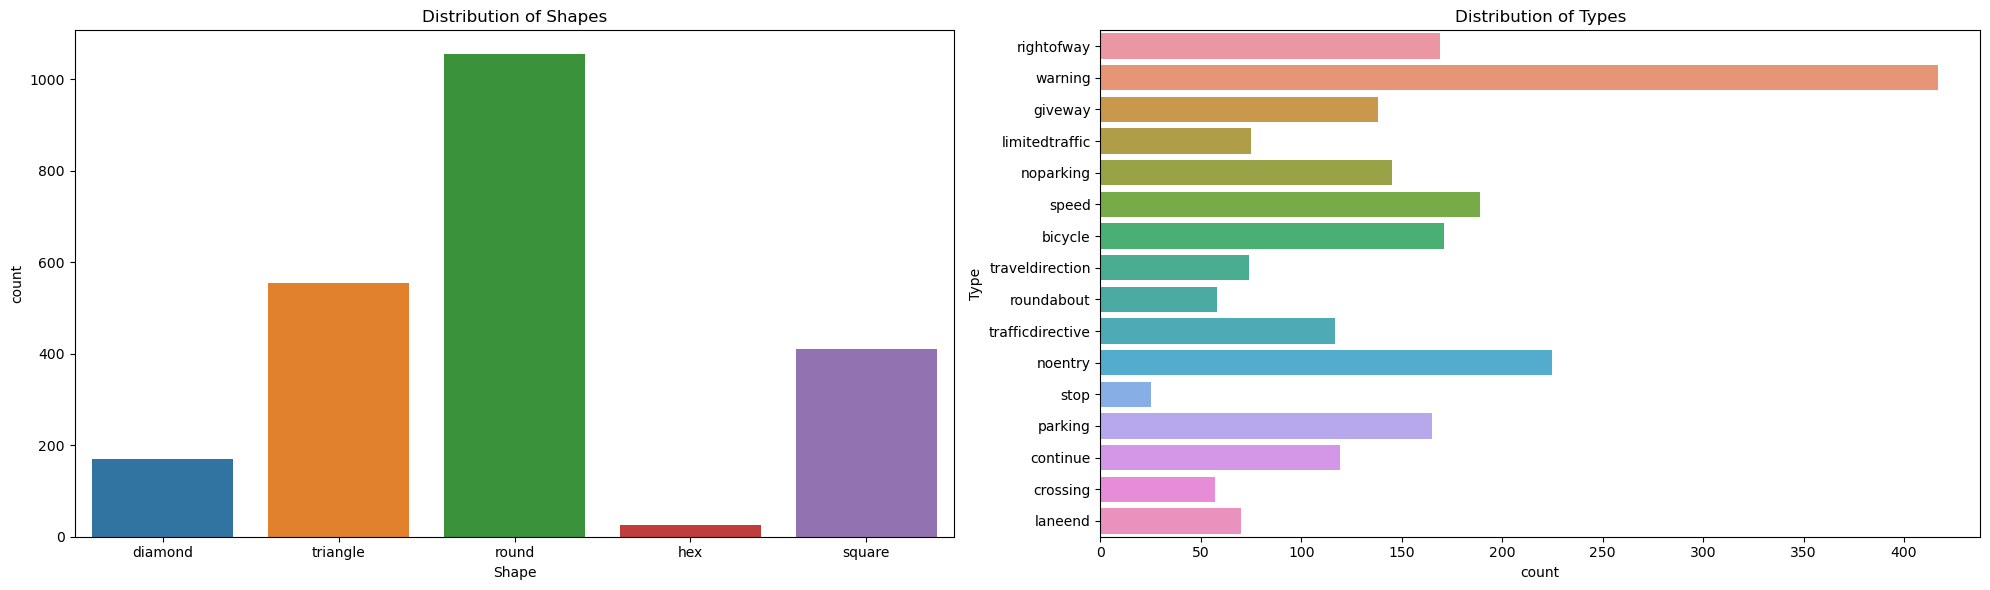

In [14]:
visualise_data(train)

In [15]:
# Iterate through each image path in the DataFrame
def check_image_dimensions(df):
    for index, row in df.iterrows():
        image_path = row['Path']
        flag = False

        # Open the image using PIL
        with Image.open(image_path) as img:
            width, height = img.size
            # Check if dimensions are not 28x28
            if width != 28 or height != 28:
                flag = True
                print(f"Image at path {image_path} has dimensions {width}x{height}")

    if not flag:
        return "All images have dimensions 28x28"

In [16]:
print(f"Train: {check_image_dimensions(train)}\n Test: {check_image_dimensions(test)}\n Val: {check_image_dimensions(val)}")    

Train: All images have dimensions 28x28
 Test: All images have dimensions 28x28
 Val: All images have dimensions 28x28


Encode class labels

In [17]:
def encoder(df):
    label_encoder = LabelEncoder()
    df['Shape'] = label_encoder.fit_transform(df['Shape'])
    df['Type'] = label_encoder.fit_transform(df['Type'])

    return df    

In [18]:
encoder(train)
encoder(test)
encoder(val)

# print(train['Shape'].value_counts())
# print(train['Type'].unique())
# train[train.Shape == 1].head()

,Path,Shape,Type
0,Dataset/train_test_val/val/diamond/rightofway/...,0,9
1,Dataset/train_test_val/val/diamond/rightofway/...,0,9
2,Dataset/train_test_val/val/diamond/rightofway/...,0,9
3,Dataset/train_test_val/val/diamond/rightofway/...,0,9
4,Dataset/train_test_val/val/diamond/rightofway/...,0,9
...,...,...,...
730,Dataset/train_test_val/val/square/laneend/0141...,3,4
731,Dataset/train_test_val/val/square/laneend/0175...,3,4
732,Dataset/train_test_val/val/square/laneend/0072...,3,4
733,Dataset/train_test_val/val/square/laneend/0013...,3,4


Handle Data Imbalance

In [19]:
def augment_data(df, image_batch_size, dest):
    
    images = []
    for image_path in df['Path']:
        img = plt.imread(image_path)
        images.append(img_to_array(img))
      

    datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
    )

    for img in images:
        img = img.reshape((1,) + img.shape)
        for j, _ in enumerate(datagen.flow(img, save_to_dir=dest, batch_size=1, save_prefix='aug', save_format='png')):
            if j >= image_batch_size:
                break


In [20]:
def make_dir(src, dest):
    if (os.path.exists(dest)):
        if dest == 'Dataset/shape_aug/train':
            shutil.rmtree(r'./Dataset/shape_aug/train')
        elif dest == 'Dataset/type_aug/train':
            shutil.rmtree(r'./Dataset/type_aug/train')
    
    shutil.copytree(src, dest)

In [21]:
def start_shape_augmentation(train, choice, src, dest, batch_dict):
    make_dir(src=src, dest=dest)
    
    for key, [index, value, shape] in batch_dict.items():
        path = dest + '/' + shape + '/' + key
        augment_data(df=train[train.Type == index], image_batch_size=value, dest=path) 
    
    train_aug = fetch_images(dest + '/*/*/*.png')
    train_aug = encoder(train_aug)
    print(train_aug[choice].value_counts())
    visualise_data(train_aug)
    return train_aug

Shape
2    1054
1    1018
3     912
4     826
0     823
Name: count, dtype: int64


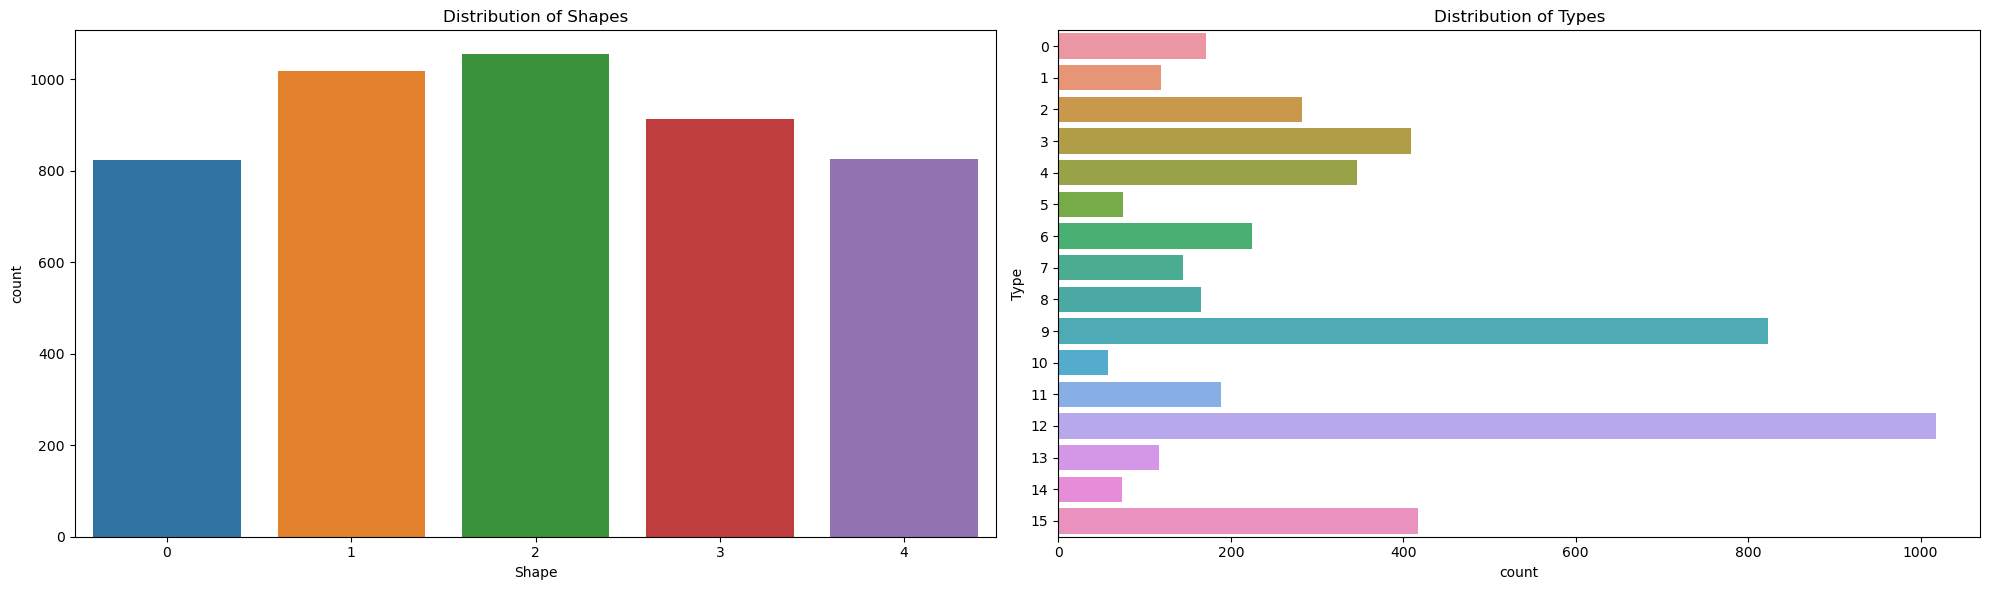

In [22]:
batch_dict_shape = {
    # sign_type : [sign_type_label, number of images to generate per image, shape]
        'stop': [12, 41, 'hex'],
        'giveway': [3, 1, 'triangle'],
        'crossing': [2, 3, 'square'],
        'laneend': [4, 3, 'square'],
        'rightofway': [9, 3, 'diamond'],
    }
train_shape_aug = start_shape_augmentation(train, 'Shape', 
                                           src='Dataset/train_test_val/train', 
                                           dest='Dataset/shape_aug/train', 
                                           batch_dict=batch_dict_shape)

Type
6     668
7     575
13    573
11    562
3     544
5     518
0     508
14    508
9     504
2     502
8     493
4     485
1     468
10    455
12    444
15    417
Name: count, dtype: int64


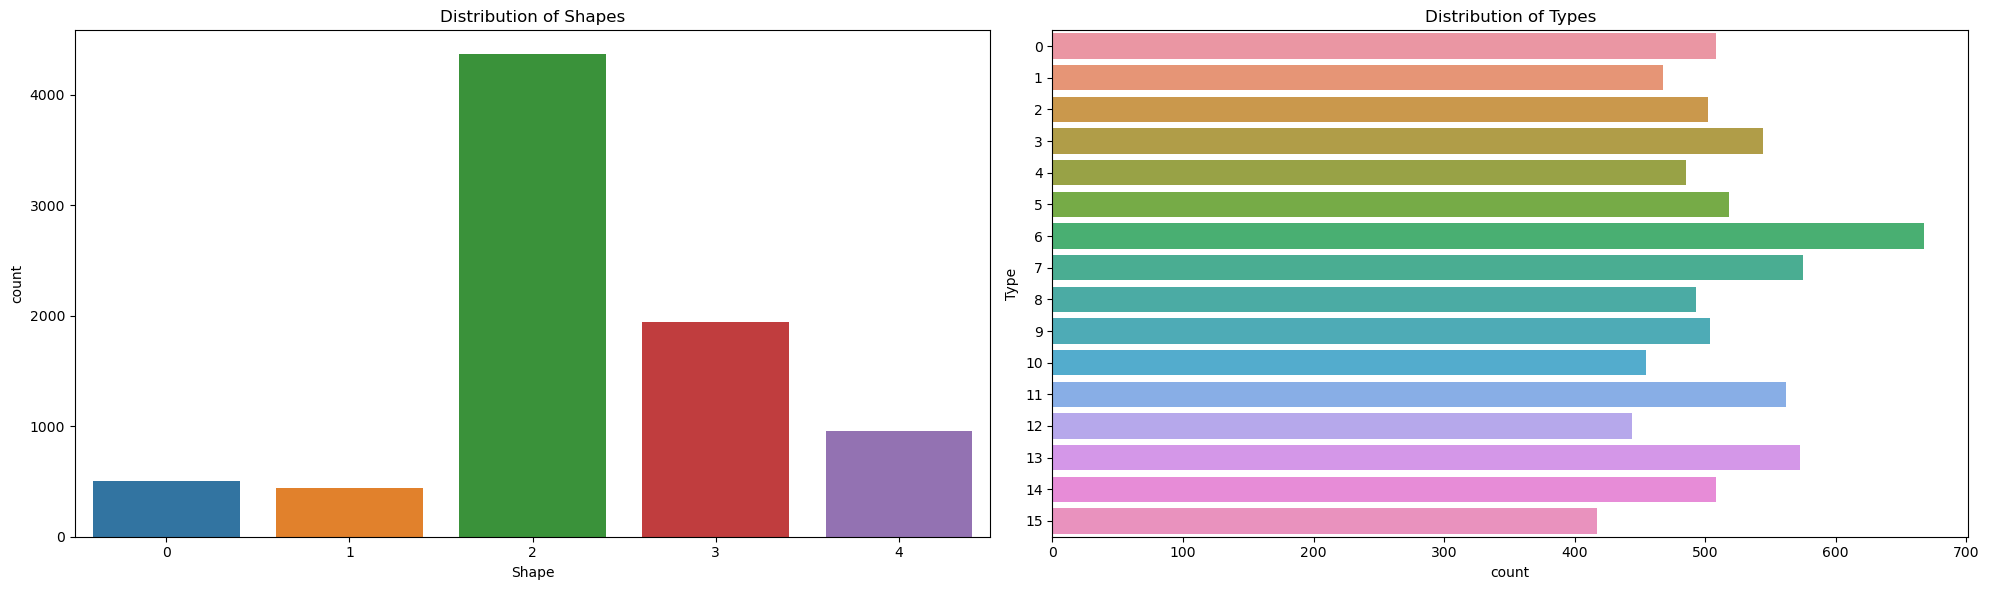

In [23]:
batch_dict_type = {
    # sign_type : [sign_type_label, number of images to generate per image, shape]
        'stop': [12, 16, 'hex'],
        'crossing': [2, 7, 'square'],
        'roundabout': [10, 6, 'round'],
        'laneend': [4, 5, 'square'],
        'traveldirection': [14, 5, 'round'],
        'limitedtraffic': [5, 5, 'round'],
        'trafficdirective': [13, 3, 'round'],
        'continue': [1, 2, 'square'],
        'giveway': [3, 2, 'triangle'],
        'noparking': [7, 2, 'round'],
        'parking': [8, 1, 'square'],
        'rightofway': [9, 1, 'diamond'],
        'bicycle': [0, 1, 'round'],
        'speed': [11, 1, 'round'], 
        'noentry': [6, 1, 'round'],
    }
train_type_augmented = start_shape_augmentation(train, 'Type', 
                                           src='Dataset/train_test_val/train', 
                                           dest='Dataset/type_aug/train', 
                                           batch_dict=batch_dict_type)

Generate Images for Training

In [24]:
def create_image_batches(df, batch_size, label, target_size=(28, 28), is_train = True):
        df[label] = df[label].astype('str')
        train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

        if is_train:
                train_generator = train_datagen.flow_from_dataframe(
                        dataframe=df,
                        directory='./',
                        x_col="Path",
                        y_col=label,
                        target_size=target_size,
                        batch_size=batch_size,
                        class_mode='categorical')
        else:
                train_generator = train_datagen.flow_from_dataframe(
                        dataframe=df,
                        directory='./',
                        x_col="Path",
                        y_col=label,
                        target_size=target_size,
                        batch_size=batch_size,
                        shuffle=False,
                        class_mode='categorical'
                        )
        
        return train_generator

In [25]:
# create image batches from train for Shape
shape_train_generator = create_image_batches(df=train, batch_size=32, label='Shape', target_size=(28, 28), is_train=True)
shape_val_generator = create_image_batches(df=val, batch_size=32, label='Shape', target_size=(28, 28), is_train=True)
# create image batches from augmented train for Shape
shape_aug_train_generator = create_image_batches(df=train_shape_aug, batch_size=32, label='Shape', target_size=(28, 28), is_train=True)

Found 2214 validated image filenames belonging to 5 classes.
Found 735 validated image filenames belonging to 5 classes.


Found 4633 validated image filenames belonging to 5 classes.


In [26]:
type_train_generator = create_image_batches(df=train, batch_size=32, label='Type', target_size=(28, 28), is_train=True)
type_val_generator = create_image_batches(df=val, batch_size=32, label='Type', target_size=(28, 28), is_train=True)
# create image batches from augmented train for Type
type_aug_train_generator = create_image_batches(df=train_type_augmented, batch_size=32, label='Type', target_size=(28, 28), is_train=True)

Found 2214 validated image filenames belonging to 16 classes.
Found 735 validated image filenames belonging to 16 classes.
Found 8224 validated image filenames belonging to 16 classes.


Model Development

In [27]:
OUTPUT_CLASSES_SHAPE = 5
OUTPUT_CLASSES_TYPE = 16
INPUT_DIM = (28, 28, 3)
# define metrics
METRIC = tf.keras.metrics.AUC(curve='PR', name='PR', from_logits=True)
LOSS_METRIC = tf.keras.losses.CategoricalCrossentropy(from_logits=True)


print(
    f"Classes_Shape: {OUTPUT_CLASSES_SHAPE}\n"
    f"Classes_Type: {OUTPUT_CLASSES_TYPE}\n"
    f"Metric: {METRIC}\n"
    f"Loss Metric: {LOSS_METRIC}\n"
)

Classes_Shape: 5
Classes_Type: 16
Metric: <AUC name=PR>
Loss Metric: <keras.src.losses.losses.CategoricalCrossentropy object at 0x78047d4c7b90>



2024-05-17 21:05:01.832001: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-17 21:05:01.855462: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [28]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [ ]:
def plot_performance(history, metric_label):
    val_metric_label = 'val_' + metric_label
    plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history[metric_label], history.history[val_metric_label], 
                    metric_name = metric_label)

In [ ]:
def calc_class_weights(df, label):
    unique_labels = train[label].unique()
    weights =  compute_class_weight(class_weight="balanced", classes=df[label].unique(), y=df[label].to_numpy())
    class_weights = dict(zip(unique_labels, weights))
    return class_weights

In [122]:
def tune_model(tuner, train_generator, val_generator, class_weights, epoch, tune_type):
    tuner.search(train_generator, validation_data=val_generator, class_weight=class_weights, epochs=epoch, verbose=0)
    best_hp = tuner.get_best_hyperparameters()[0]
    tuned_val = best_hp.get(tune_type)
    print(f"Best {tune_type}: {tuned_val}")
    model = tuner.hypermodel.build(best_hp)
    history = model.fit(train_generator, validation_data=val_generator, epochs=epoch, verbose=0, class_weight=class_weights)
    plot_performance(history=history, metric_label='PR')
    return model

Fetch class weights

In [126]:
shape_weights = calc_class_weights(df=train, label='Shape')
shape_weights

{'0': 2.620118343195266,
 '4': 0.7978378378378378,
 '2': 0.42011385199240986,
 '1': 17.712,
 '3': 1.0773722627737226}

In [127]:
type_weights = calc_class_weights(df=train, label='Type')
type_weights

{'9': 0.8187869822485208,
 '15': 0.3318345323741007,
 '3': 1.002717391304348,
 '5': 1.845,
 '7': 0.9543103448275863,
 '11': 0.7321428571428571,
 '0': 0.8092105263157895,
 '14': 1.8699324324324325,
 '10': 2.3857758620689653,
 '13': 1.1826923076923077,
 '6': 0.615,
 '12': 5.535,
 '8': 0.8386363636363636,
 '1': 1.1628151260504203,
 '2': 2.4276315789473686,
 '4': 1.9767857142857144}

### Models

Base MLP

In [ ]:
################### ADD YOUR BASELINE MLP HERE ################

Base VGG

In [ ]:
def build_model_VGG(input_shape, output_classes, activation='relu'):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(28, (3, 3), activation=activation, padding='same', input_shape=input_shape),
        tf.keras.layers.Conv2D(28, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
   
        tf.keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Conv2D(128, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.Conv2D(128, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=activation),
        tf.keras.layers.Dense(output_classes, activation='softmax'),
    ])

    return model

Tuneable VGG with L2 Regularization

In [124]:
def build_model_VGG_reg(hp):    
    lambda_value = hp.Float('lambda', min_value=0.0001, max_value=0.1, sampling='log', default=0.001)
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value), input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE, activation = "softmax"),
    ])

    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=[METRIC])

    return model

Tunable VGG with Dropout Regularization

In [125]:
def build_model_VGG_dropout(hp):    
    # from lambda tuner
    #lambda_value = 0.018037870215070927
    lambda_value = 0.006407366308178109
    dropout_value = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, default=0.2, step=0.1)
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value), input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(dropout_value),
        tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE, activation = "softmax"),
    ])

    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=[METRIC])

    return model

### Tuners

Lambda Tuner

In [128]:
# Initialize the l2 tuner
lambda_tuner = kt.RandomSearch(
    build_model_VGG_reg,
    objective='val_loss',
    max_trials=3,
    project_name='lambda_tuning')

Reloading Tuner from ./lambda_tuning/tuner0.json


Dropout Tuner

In [ ]:
# Initialize the droput tuner
dropout_tuner = kt.RandomSearch(
    build_model_VGG_dropout,
    objective='val_loss',
    max_trials=5,
    project_name='dropout_tuning')

Baseline Model

In [29]:
# Add your baseline model here

Convolutional Neural Network (CNN)

In [31]:
def compile_model(model, optimiser='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy']):
    model.compile(optimizer=optimiser, loss=loss, metrics=metrics)
    return model

In [32]:
def train_model(model, train_generator, val_generator, epochs=50, class_weights=None):
    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, class_weight=class_weights, verbose=0)
    return history

In [34]:
def pipeline(train, val, metric_label, optimiser, activation, epoch, class_weights):
    model = build_model_VGG(input_shape=INPUT_DIM, output_classes=OUTPUT_CLASSES_SHAPE, activation=activation)
    model = compile_model(model, optimiser=optimiser, loss=LOSS_METRIC, metrics=[METRIC])
    history = train_model(model, train, val, epochs=epoch, class_weights=class_weights)
    plot_performance(history=history, metric_label=metric_label)
    return model


VGG with Adam Optimiser

In [ ]:
model_VGG_base_adam_shape = pipeline(shape_train_generator, 
                          shape_val_generator, 
                          metric_label='PR',
                          optimiser='adam',
                          activation='relu',
                          epoch=100,
                          class_weights=None)

VGG with SGD Optimiser

In [ ]:
model_VGG_base_SGD_shape = pipeline(shape_train_generator, 
                          shape_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          class_weights=None)

In [87]:
model_VGG_base_SGD_shape.save('models/shape/model_VGG_base_SGD_shape.keras')

Class Re-Weighting

VGG with Class Re-Weighting

In [ ]:
model_VGG_base_SGD_shape_reweighted = pipeline(shape_train_generator, 
                          shape_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          class_weights=shape_weights)

In [86]:
model_VGG_base_SGD_shape_reweighted.save('models/shape/model_VGG_base_SGD_shape_reweighted.keras')

L2 Regularisation

In [ ]:
best_model_l2_shape = tune_model(lambda_tuner, shape_train_generator, shape_val_generator, shape_weights, 100, 'lambda')

In [85]:
best_model_l2_shape.save('models/shape/best_model_l2_shape.keras')

Dropout Regularisation

In [ ]:
best_model_droput_shape = tune_model(dropout_tuner, shape_train_generator, shape_val_generator, shape_weights, 100, 'dropout_rate')

In [88]:
best_model_droput_shape.save('models/shape/best_model_droput_shape.keras')

Augmented Data

In [ ]:
model_VGG_base_SGD_shape_aug = pipeline(shape_aug_train_generator, 
                          shape_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          class_weights=None)

In [89]:
model_VGG_base_SGD_shape_aug.save('models/shape/model_VGG_base_SGD_shape_aug.keras')

Regularisation

In [ ]:
best_model_l2_shape_aug = tune_model(lambda_tuner, shape_aug_train_generator, shape_val_generator, shape_weights, 100, 'lambda')

In [90]:
best_model_l2_shape_aug.save('models/shape/best_model_l2_shape_aug.keras')

Dropout

In [ ]:
best_model_dropout_shape_aug = tune_model(dropout_tuner, shape_aug_train_generator, shape_val_generator, shape_weights, 100, 'dropout_rate')

In [ ]:
best_model_dropout_shape_aug.save('models/shape/best_model_droput_shape_aug.keras')

Type

Base SGD Optimiser

In [ ]:
model_VGG_base_SGD_type = pipeline(type_train_generator, 
                          type_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          class_weights=None)

In [ ]:
model_VGG_base_SGD_type.save('models/type/model_VGG_base_SGD_type.keras')

Reweighted SGD Optimiser

In [ ]:
model_VGG_base_SGD_type_reweighted = pipeline(type_train_generator, 
                          type_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          class_weights=type_weights)

In [ ]:
model_VGG_base_SGD_type_reweighted.save('models/type/model_VGG_base_SGD_type_reweighted.keras')

L2 Regularisation

In [ ]:
best_model_l2_type = tune_model(lambda_tuner, type_train_generator, type_val_generator, type_weights, 100, 'lambda')

In [ ]:
best_model_l2_type.save('models/type/best_model_l2_type.keras')

Dropout Regularisation

In [ ]:
best_model_droput_type = tune_model(dropout_tuner, type_train_generator, type_val_generator, type_weights, 100, 'dropout_rate')

In [ ]:
best_model_droput_type.save('models/type/best_model_droput_type.keras')

Augmented Data

In [ ]:
model_VGG_base_SGD_type_aug = pipeline(type_aug_train_generator, 
                          type_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          class_weights=None)

In [ ]:
model_VGG_base_SGD_type_aug.save('models/type/model_VGG_base_SGD_type_aug.keras')

L2 Regularisation

In [ ]:
best_model_l2_type_aug = tune_model(lambda_tuner, type_aug_train_generator, type_val_generator, type_weights, 100, 'lambda')

In [ ]:
best_model_l2_type_aug.save('models/type/best_model_l2_type_aug.keras')

Dropout Regularisation

In [ ]:
best_model_droput_type_aug = tune_model(dropout_tuner, type_aug_train_generator, type_val_generator, type_weights, 100, 'dropout_rate')

In [ ]:
best_model_droput_type_aug.save('models/type/best_model_droput_type_aug.keras')

### Testing